# 목차

* 평가문항
* MNLI데이터셋 분석
* MNLIProcessor 클래스 구현
* Tokenizer와 Model
* Train/Evaluation과 Test
* 회고
* Reference

# 평가문항

상세기준

1. MNLI 데이터셋을 처리하는 전용 Processor 클래스를 정상적으로 구현하였다.

> Processor 클래스에 대해 1개 이상의 example에 대한 단위테스트가 정상 진행되었다.

2. BERT tokenizer와 Processor를 결합하여 데이터셋을 정상적으로 생성하였다.

> MNLI 데이터셋의 입력과 라벨의 정의에 잘 맞는 tf.data.Dataset 인스턴스가 얻어졌다.

3. MNLI 데이터셋에 대해 적당한 모델을 fine-tuning하여 학습하였다.

> 모델 학습이 정상적으로 진행되었다.

In [ ]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 13.8 MB/s 
     |████████████████████████████████| 182 kB 98.7 MB/s 
     |████████████████████████████████| 7.6 MB 86.2 MB/s 


In [ ]:
%pip install tensorflow-datasets -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 14.4 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.6.0
    Uninstalling tensorflow-datasets-4.6.0:
      Successfully uninstalled tensorflow-datasets-4.6.0


In [ ]:
%pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 14.7 MB/s 
     |████████████████████████████████| 213 kB 95.0 MB/s 
     |████████████████████████████████| 132 kB 94.8 MB/s 
     |████████████████████████████████| 127 kB 97.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import os
import numpy as np
from argparse import ArgumentParser
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, AutoConfig
from dataclasses import asdict
from transformers.data.processors.utils import DataProcessor, InputExample, InputFeatures

# mnli 데이터셋 분석

MNLI : 두 문장의 관계 판단(entailment, contradiction, neutral)

In [ ]:
data, info = tfds.load('glue/mnli', with_info=True)
info.splits['train'].num_examples

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/5 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/392702 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mnli/2.0.0.incompleteMLAHYM/glue-train.tfrecord*...:   0%|          |…

Generating validation_matched examples...:   0%|          | 0/9815 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mnli/2.0.0.incompleteMLAHYM/glue-validation_matched.tfrecord*...:   0…

Generating validation_mismatched examples...:   0%|          | 0/9832 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mnli/2.0.0.incompleteMLAHYM/glue-validation_mismatched.tfrecord*...: …

Generating test_matched examples...:   0%|          | 0/9796 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mnli/2.0.0.incompleteMLAHYM/glue-test_matched.tfrecord*...:   0%|    …

Generating test_mismatched examples...:   0%|          | 0/9847 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mnli/2.0.0.incompleteMLAHYM/glue-test_mismatched.tfrecord*...:   0%| …

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mnli/2.0.0. Subsequent calls will reuse this data.


392702

In [ ]:
info

tfds.core.DatasetInfo(
    name='glue',
    full_name='glue/mnli/2.0.0',
    description="""
    GLUE, the General Language Understanding Evaluation benchmark
    (https://gluebenchmark.com/) is a collection of resources for training,
    evaluating, and analyzing natural language understanding systems.
    """,
    config_description="""
    The Multi-Genre Natural Language Inference Corpus is a crowdsourced
    collection of sentence pairs with textual entailment annotations. Given a premise sentence
    and a hypothesis sentence, the task is to predict whether the premise entails the hypothesis
    (entailment), contradicts the hypothesis (contradiction), or neither (neutral). The premise sentences are
    gathered from ten different sources, including transcribed speech, fiction, and government reports.
    We use the standard test set, for which we obtained private labels from the authors, and evaluate
    on both the matched (in-domain) and mismatched (cross-domain) section. We a

In [ ]:
# 우선 몇 개의 데이터만 살펴보자

data['train'].take(1)

<TakeDataset element_spec={'hypothesis': TensorSpec(shape=(), dtype=tf.string, name=None), 'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'premise': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [ ]:

examples = data['train'].take(10)
for example in examples:
    hypothesis = example['hypothesis']
    premise = example['premise']
    label = example['label']
    print()
    print(hypothesis)
    print(premise)
    print(label)


tf.Tensor(b'Meaningful partnerships with stakeholders is crucial.', shape=(), dtype=string)
tf.Tensor(b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)

tf.Tensor(b'The Clinton followers kept to the higher ground in the discussion. ', shape=(), dtype=string)
tf.Tensor(b'The Clinton surrogates also held the high ground in the context war.', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)

tf.Tensor(b'Women have jobs in all areas of the workforce, they are almost getting the same wages as most men,', shape=(), dtype=string)
tf.Tensor(b"um-hum because women are in every field now i mean i can't think of a field that they're not involved in", shape=(), dtype=string)
tf.Ten

MNLI 데이터셋에 대해 조사해본 결과 label은 0: entailment, 1: neutral, 2: contradiction 을 의미한다는 사실을 알 수 있었다. 위 예시들과 비교했을 때도 그것이 옳다고 보인다.

#  MNLIProcessor 클래스 구현

추상클래스인 Processor를 한번 상속받은 후, Sequence Classification task를 수행하는 모델의 Processor 추상클래스인 DataProcessor 이다.

In [ ]:
class DataProcessor:
    """Base class for data converters for sequence classification data sets."""

    def get_example_from_tensor_dict(self, tensor_dict):
        """
        Gets an example from a dict with tensorflow tensors.

        Args:
            tensor_dict: Keys and values should match the corresponding Glue
                tensorflow_dataset examples.
        """
        raise NotImplementedError()

    def get_train_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the dev set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the test set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    def tfds_map(self, example):
        """
        Some tensorflow_datasets datasets are not formatted the same way the GLUE datasets are. This method converts
        examples to the correct format.
        """
        if len(self.get_labels()) > 1:
            example.label = self.get_labels()[int(example.label)]
        return example

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            return list(csv.reader(f, delimiter="\t", quotechar=quotechar))


우선 클래스만 선언한다.

In [ ]:
class MnliProcessor(DataProcessor):
    """Processor for the MNLI data set (GLUE version)."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["hypothesis"].numpy().decode("utf-8"),
            tensor_dict["premise"].numpy().decode("utf-8"),
            str(tensor_dict["label"].numpy()),
        )

    def get_train_examples(self, data_dir):
        """See base class."""
        print("LOOKING AT {}".format(os.path.join(data_dir, "train.tsv")))
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

    def get_labels(self):
        """See base class."""
        return ["0", "1", "2"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training, dev and test sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            text_b = line[4]
            label = None if set_type == "test" else line[0]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples


In [ ]:
processor = MnliProcessor()
examples = data['train'].take(1)

for example in examples:
    print('------원본데이터------')
    print(example)  
    example = processor.get_example_from_tensor_dict(example)
    print('------processor 가공데이터------')
    print(example)

------원본데이터------
{'hypothesis': <tf.Tensor: shape=(), dtype=string, numpy=b'Meaningful partnerships with stakeholders is crucial.'>, 'idx': <tf.Tensor: shape=(), dtype=int32, numpy=16399>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'premise': <tf.Tensor: shape=(), dtype=string, numpy=b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.'>}
------processor 가공데이터------
InputExample(guid=16399, text_a='Meaningful partnerships with stakeholders is crucial.', text_b='In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal

In [ ]:
examples = (data['train'].take(1))
for example in examples:
    example = processor.get_example_from_tensor_dict(example)
    example = processor.tfds_map(example)
    print(example)

InputExample(guid=16399, text_a='Meaningful partnerships with stakeholders is crucial.', text_b='In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.', label='1')


위 코드는 tfds_map() 메소드를 활용한 경우이다. 이전과 별다른 차이는 없는데, tfds_map는 label을 가공하는 메소드라서 이미 숫자로 잘 가공된 label을 가지고 있으므로 특별한 변화가 없습니다.

실제 label을 확인하여 Binary Classification 문제로 잘 정의되고 있는지 확인해보자.

In [ ]:
label_list = processor.get_labels()
label_list

['0', '1', '2']

In [ ]:
label_map = {label: i for i, label in enumerate(label_list)}
label_map

{'0': 0, '1': 1, '2': 2}

In [ ]:
# huggingface를 이용하는 방법

import datasets
from datasets import load_dataset

huggingface_mnli_dataset = load_dataset('glue', 'mnli')
print(huggingface_mnli_dataset)

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})


- Huggingface에서 제공하는 datasets를 이용하는 방법이다. 각 데이터들의 정보를 볼 수 있다.

# Tokenizer와 Model



## framework를 이용하는 방법

이전 스텝에서 만든 MNLIProcessor 클래스와 framework를 결합시켜 나가는 과정을 진행한다.

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
def _glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="claasification") :
    if max_length is None :
        max_length = tokenizer.max_len
    if label_list is None:
        label_list = processor.get_labels()
        print("Using label list %s" % (label_list))

    label_map = {label: i for i, label in enumerate(label_list)}
    labels = [label_map[example.label] for example in examples]

    batch_encoding = tokenizer(
        [(example.text_a, example.text_b) for example in examples],
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )

    features = []
    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

    for i, example in enumerate(examples[:5]):
        print("*** Example ***")
        print("guid: %s" % (example.guid))
        print("features: %s" % features[i])

    return features

In [ ]:
def tf_glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="classification") :
    """
    :param examples: tf.data.Dataset
    :param tokenizer: pretrained tokenizer
    :param max_length: example의 최대 길이(기본값 : tokenizer의 max_len)
    :param task: GLUE task 이름
    :param label_list: 라벨 리스트
    :param output_mode: "regression" or "classification"

    :return: task에 맞도록 feature가 구성된 tf.data.Dataset
    """
    examples = [processor.tfds_map(processor.get_example_from_tensor_dict(example)) for example in examples]
    features = _glue_convert_examples_to_features(examples, tokenizer, max_length, processor)
    label_type = tf.int64

    def gen():
        for ex in features:
            d = {k: v for k, v in asdict(ex).items() if v is not None}
            label = d.pop("label")
            yield (d, label)

    input_names = ["input_ids"] + tokenizer.model_input_names

    return tf.data.Dataset.from_generator(
        gen,
        ({k: tf.int32 for k in input_names}, label_type),
        ({k: tf.TensorShape([None]) for k in input_names}, tf.TensorShape([])),
    )

아래에서 경고가 발생하는데 아무래도 truncation=True를 사용하기 때문에 그것에 대한 경고 메세지가 지속적으로 발생한 듯하다.

In [ ]:
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, processor=processor)

Using label list ['0', '1', '2']


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

*** Example ***
guid: 16399
features: InputFeatures(input_ids=[101, 15902, 13797, 2007, 22859, 2003, 10232, 1012, 102, 1999, 5038, 1997, 2122, 13136, 1010, 1048, 11020, 2038, 2499, 29454, 29206, 14626, 2144, 2786, 2000, 16636, 1996, 10908, 1997, 1996, 2110, 4041, 6349, 1998, 2000, 5323, 15902, 13797, 2007, 22859, 6461, 2012, 6469, 2075, 1037, 2047, 25353, 14905, 10735, 2483, 2090, 1996, 2976, 10802, 1998, 15991, 1997, 3423, 2578, 4804, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# train 데이터셋
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, processor=processor)
train_dataset_batch = train_dataset.shuffle(100).batch(16).repeat(2)

Using label list ['0', '1', '2']


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

*** Example ***
guid: 16399
features: InputFeatures(input_ids=[101, 15902, 13797, 2007, 22859, 2003, 10232, 1012, 102, 1999, 5038, 1997, 2122, 13136, 1010, 1048, 11020, 2038, 2499, 29454, 29206, 14626, 2144, 2786, 2000, 16636, 1996, 10908, 1997, 1996, 2110, 4041, 6349, 1998, 2000, 5323, 15902, 13797, 2007, 22859, 6461, 2012, 6469, 2075, 1037, 2047, 25353, 14905, 10735, 2483, 2090, 1996, 2976, 10802, 1998, 15991, 1997, 3423, 2578, 4804, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# validation 데이터셋
validation_dataset = tf_glue_convert_examples_to_features(data['validation_matched'], tokenizer, max_length=128, processor=processor)
validation_dataset_batch = validation_dataset.shuffle(100).batch(16)

Using label list ['0', '1', '2']


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

*** Example ***
guid: 6287
features: InputFeatures(input_ids=[101, 3398, 7167, 1997, 2111, 2005, 1996, 2157, 2166, 102, 7910, 1011, 9616, 2821, 3398, 2035, 1996, 2111, 2005, 2157, 7910, 2166, 2030, 2242, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=None, label=0)
*** Example ***
guid: 1579
features: InputFeatures

In [ ]:
# test 데이터셋
test_dataset = tf_glue_convert_examples_to_features(data['test_matched'], tokenizer, max_length=128, processor=processor)
test_dataset_batch = test_dataset.shuffle(100).batch(16)

Using label list ['0', '1', '2']


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

*** Example ***
guid: 5398
features: InputFeatures(input_ids=[101, 2003, 2045, 1037, 10216, 2008, 2017, 2404, 1999, 2045, 1029, 102, 2092, 2003, 2045, 1037, 2210, 3751, 10216, 2017, 2404, 1999, 2045, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=None, label=2)
*** Example ***
guid: 1921
features: InputFeatures(

## Huggingface Auto Classes를 이용하는 방법

Huggingface의 distilbert를 사용해보자

https://huggingface.co/huggingface/distilbert-base-uncased-finetuned-mnli

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

huggingface_tokenizer = AutoTokenizer.from_pretrained("huggingface/distilbert-base-uncased-finetuned-mnli")

huggingface_model = AutoModelForSequenceClassification.from_pretrained("huggingface/distilbert-base-uncased-finetuned-mnli", num_labels=3)

Downloading:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/729 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

우선 Huggingface Auto Classes를 이용하여 tokenizer와 model을 간단히 생성한다



이와 관련해 노드에 있는 내용을 인용하자면

---
Huggingface의 경우 AutoTokenizer, AutoModel기능을 지원합니다.

AutoTokenizer와 AutoModel은 Huggingface에서 지원하는 Auto Class입니다.

Auto class는 from_pretrained 메소드를 이용해 pretrained model의 경로 혹은 이름만 안다면 자동으로 생성하는 방법입니다.

즉 bert를 사용할때 BertTokenizer, RoBERTa를 사용할때 RobertaTokenizer를 사용하게 되는데 AutoTokenizer를 이용하면 자동으로 BERT모델은 BERT로 RoBERTa모델은 RoBERTa로 바꿔줍니다.

model도 마찬가지입니다. 다만 model의 경우 AutoModel을 그대로 사용하기보다 특정 task를 지정하는 방식인 AutoModelForSequenceClassification을 사용하는걸 권장드립니다.

Auto class는 다양한 모델에 자동으로 맞출 수 있기 떄문에 특정 task와 dataset이 주어져있는 경우 모델을 다양하게 넣어 실험할 수 있습니다.

그렇기에 Auto class를 유용하게 활용하는 것을 추천합니다.

Tokenizer와 Model을 만들었다면 이제 토크나이징하는 방법을 알아보도록 하겠습니다.

토크나이징은 transform이라는 함수를 만들고 이전에 만들어두었던 Tokenizer를 사용하는데 이때 dataset의 형태를 확인하고 바꿀 대상을 지정해야 합니다.

mrpc의 경우 sentence1, sentence2가 토크나이징할 대상이므로 data[’sentence1’], data[’sentence2’]로 인덱싱해서 지정합니다.

truncation은 특정 문장이 길어 모델을 다루기 힘들어 질 수 있으므로 짧게 자르는 것을 의미합니다.

return_token_type_ids는 문장이 한개이상일 때 나뉘는걸 보여줍니다. (해당 내용은 task에 필요없으므로 제거합니다)

---

예시까지 확인하면 다음과 같이 나온다.

In [ ]:
def transform(data):
  return huggingface_tokenizer(
      data['hypothesis'],
      data['premise'],
      truncation = True,
      padding = 'max_length',
      return_token_type_ids = False,
      )
  
examples = huggingface_mnli_dataset['train'][:5]
examples_transformed = transform(examples)

print(examples)
print(examples_transformed)

{'premise': ['Conceptually cream skimming has two basic dimensions - product and geography.', 'you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him', 'One of our number will carry out your instructions minutely.', 'How do you know? All this is their information again.', "yeah i tell you what though if you go price some of those tennis shoes i can see why now you know they're getting up in the hundred dollar range"], 'hypothesis': ['Product and geography are what make cream skimming work. ', 'You lose the things to the following level if the people recall.', 'A member of my team will execute your orders with immense precision.', 'This information belongs to them.', 'The tennis shoes have a range of prices.'], 'label': [1, 0, 0, 0, 1], 'idx': [0, 1, 2, 3, 4]}
{'inp

In [ ]:
encoded_dataset = huggingface_mnli_dataset.map(transform, batched=True)

  0%|          | 0/393 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [ ]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 9847
    })
})

데이터셋을 한번에 토크나이징할때 자주 사용하는 기법은 map이다.

map을 사용하게 되면 Data dictionary에 있는 모든 데이터들이 빠르게 적용시킬 수 있다.

우리는 map을 사용해 토크나이징을 진행하기 때문에 batch를 적용해야 되므로 batched=True로 둔다.

# Train/Evaluation과 Test

시간 관계상 3epoch만 학습을 진행한다.

## tf.keras.model 을 활용한 학습

우선, 우리에게 익숙한 model.fit()을 이용한 모델학습을 진행해보자.

In [ ]:
num_classes = len(processor.get_labels())

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 이전 스텝에서 배치처리를 진행한 데이터셋(xxxx_dataset_batch)을 활용
model.fit(train_dataset_batch, epochs=3, steps_per_epoch=115, 
                validation_data=validation_dataset_batch)

Epoch 1/3
115/115 [==============================] - 32s 190ms/step - loss: 1.0631 - acc: 0.4168 - val_loss: 0.9733 - val_acc: 0.5440
Epoch 2/3
115/115 [==============================] - 20s 173ms/step - loss: 0.9208 - acc: 0.5826 - val_loss: 0.8840 - val_acc: 0.6067
Epoch 3/3
115/115 [==============================] - 20s 172ms/step - loss: 0.8737 - acc: 0.6022 - val_loss: 0.8262 - val_acc: 0.6401


In [ ]:
result = model.evaluate(test_dataset_batch)
print(result)

613/613 [==============================] - 16s 25ms/step - loss: 1.4484 - acc: 0.2793
[1.4483656883239746, 0.27929767966270447]


In [ ]:
import os
output_dir = '/content/drive/MyDrive/GD/transformers'
output_eval_file = os.path.join(output_dir, "eval_results.txt")

with open(output_eval_file, "w") as writer:
    for i, v in enumerate(result) :
        if i == 0 :
            writer.write("Loss = %f\t" %(v))
        if i == 1 :
            writer.write("Accuracy = %f\n" %(v))
print("완료=3")

#파일에 쓴 테스트 결과 확인
!cat /content/drive/MyDrive/GD/transformers/eval_results.txt

완료=3
Loss = 1.448366	Accuracy = 0.279298


## Huggingface에서 Trainer을 활용한 학습

Trainer를 사용하기 위해서는 TrainingArguments를 통해 학습 관련 설정을 미리 지정해야 한다.

In [ ]:
'''
#메모리를 비워줍니다.
del model
del train_dataset_batch
del validation_dataset_batch
del test_dataset_batch
'''

'\n#메모리를 비워줍니다.\ndel model\ndel train_dataset_batch\ndel validation_dataset_batch\ndel test_dataset_batch\n'

In [ ]:
# Trainer을 활용하는 형태로 모델 재생성
from transformers import Trainer, TrainingArguments
output_dir = '/content/drive/MyDrive/GD/transformers'
metric_name = 'accuracy'

training_arguments = TrainingArguments(
    output_dir, # output이 저장될 경로
    evaluation_strategy="epoch", #evaluation하는 빈도
    learning_rate = 2e-5, #learning_rate
    per_device_train_batch_size = 16, # 각 device 당 batch size
    per_device_eval_batch_size = 16, # evaluation 시에 batch size
    num_train_epochs = 3, # train 시킬 총 epochs
    weight_decay = 0.01, # weight decay
)

In [ ]:
%pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 7.6 MB/s 


In [ ]:
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

In [ ]:
import gc

gc.collect()

0

In [ ]:
trainer = Trainer(
    model=huggingface_model,                           # 학습시킬 model
    args=training_arguments,                  # TrainingArguments을 통해 설정한 arguments
    train_dataset=encoded_dataset['train'],    # training dataset
    eval_dataset=encoded_dataset['validation_matched'],       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: idx, hypothesis, premise. If idx, hypothesis, premise are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 392702
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 73632
  Number of trainable parameters = 66955779


Epoch,Training Loss,Validation Loss,Accuracy
1,0.417400,0.489805,0.820173
2,0.294800,0.540960,0.820071
3,0.209800,0.736100,0.822517


Saving model checkpoint to /content/drive/MyDrive/GD/transformers/checkpoint-500
Configuration saved in /content/drive/MyDrive/GD/transformers/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/GD/transformers/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/GD/transformers/checkpoint-1000
Configuration saved in /content/drive/MyDrive/GD/transformers/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/GD/transformers/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/GD/transformers/checkpoint-1500
Configuration saved in /content/drive/MyDrive/GD/transformers/checkpoint-1500/config.json
Model weights saved in /content/drive/MyDrive/GD/transformers/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/GD/transformers/checkpoint-2000
Configuration saved in /content/drive/MyDrive/GD/transformers/checkpoint-2000/config.json
Model weights saved in /con

TrainOutput(global_step=73632, training_loss=0.3112278520827809, metrics={'train_runtime': 15290.245, 'train_samples_per_second': 77.05, 'train_steps_per_second': 4.816, 'total_flos': 1.5606342028094054e+17, 'train_loss': 0.3112278520827809, 'epoch': 3.0})

3epochs를 학습시키는 데에 LMS 기준 14시간 이상의 소요시간이 예상되었고 그것보다 더 성능이 뛰어난 환경인 Colab pro에서도 4시간이 넘게 걸렸다.

In [ ]:
trainer.evaluate(encoded_dataset['test_matched'])

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: idx, hypothesis, premise. If idx, hypothesis, premise are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9796
  Batch size = 16


RuntimeError: ignored

In [ ]:
encoded_dataset['test_matched'][0]

{'premise': 'Hierbas, ans seco, ans dulce, and frigola are just a few names worth keeping a look-out for.',
 'hypothesis': 'Hierbas is a name worth looking out for.',
 'label': -1,
 'idx': 0,
 'input_ids': [101,
  7632,
  2121,
  22083,
  2003,
  1037,
  2171,
  4276,
  2559,
  2041,
  2005,
  1012,
  102,
  7632,
  2121,
  22083,
  1010,
  2019,
  2015,
  10819,
  2080,
  1010,
  2019,
  2015,
  4241,
  23314,
  1010,
  1998,
  10424,
  14031,
  2721,
  2024,
  2074,
  1037,
  2261,
  3415,
  4276,
  4363,
  1037,
  2298,
  1011,
  2041,
  2005,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

위에서 학습 이후 evaluate가 제대로 진행되지 않는데 그 이유는 테스트 데이터셋의 label 때문이다.

# 회고

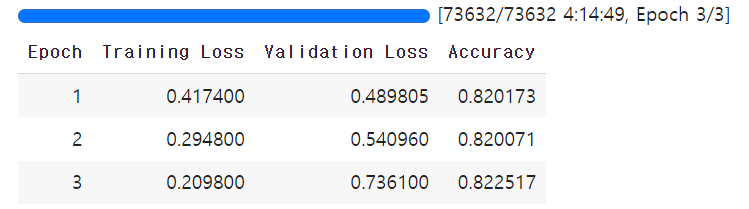

- 위 사진은 huggingface의 Auto Classes로 3epochs를 학습시킨 결과이다.

---
이번 실습에서는 huggingface를 이용해 모델을 만들었다. huggingface가 자연어처리 태스크를 진행하기 위한 좋은 도구들을 제공해주기 때문에 비교적 쉽게 목표를 달성할 수 있었다. 학습, 검증, 테스트를 위한 데이터셋 뿐만 아니라 사전학습된 모델까지 주어져 약간의 파인튜닝만으로 모델의 학습을 끝낼 수 있었다.

Framework를 이용하는 방법과 Auto Classes를 이용하는 방법을 서로 성능면에서 비교해보고 싶었지만 다른 모델을 썼기 때문에 어려워 보인다. 일단 Framework를 썼을 땐 학습의 진행속도는 빨랐지만 테스트의 결과는 좋지 않았다. 그러나 학습 과정에서 정확도가 의미있는 증가치를 보였기 때문에 epoch을 늘렸다면 훨씬 정확도가 높았을 수도 있다.

반대로 Auto classes와 Trainer를 이용했을 때엔 학습에 시간이 매우 오래 걸렸다. 그리고 학습 결과를 보면 알 수 있듯이 3epochs 뿐이었음에도 바로 과적합이 발생하고 말았다. huggingface를 쓸 땐 사전학습된 모델을 받아오므로 조금의 반복만으로 과적합이 생긴 것이다. 만약 1epoch만 돌렸다면 시간도 절약하고 성능도 더 괜찮았을 것으로 추측된다. 학습 이후 테스트를 하는 데에 실패했는데 이는 테스트 데이터셋의 label이 전부 -1로 되어있어 테스트가 불가능했기 때문이다. 아무래도 kaggle 평가용 데이터셋이어서 치팅을 방지하기 위해 이렇게 만들어진 것으로 보인다.

huggingface를 쓰면서 이것이 가진 힘을 충분히 느껴볼 수 있었다. 만약 우리가 하고자 하는 일에 적합한 도구들을 찾을 수만 있다면 무엇을 하든 매우 효율적으로 쉽게 처리할 수 있을 것이다. 지금은 비록 모델을 가져와서 그냥 사용했지만 사이트에서 파일을 직접 보거나 다운로드 받을 수 있으므로 입맛에 맞게 변형하거나 참고할 수도 있을 것이다.

# Reference

https://blog.naver.com/jcd1209/222617922468 Trainer()의 파라미터

https://blog.winterjung.dev/2018/02/18/python-gc 가비지컬렉션에 대해